In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0


In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [6]:
df = pd.read_csv('energydata_complete.csv')
print(df.head)

<bound method NDFrame.head of                       date  Appliances  lights         T1       RH_1  \
0      2016-01-11 17:00:00          60      30  19.890000  47.596667   
1      2016-01-11 17:10:00          60      30  19.890000  46.693333   
2      2016-01-11 17:20:00          50      30  19.890000  46.300000   
3      2016-01-11 17:30:00          50      40  19.890000  46.066667   
4      2016-01-11 17:40:00          60      40  19.890000  46.333333   
...                    ...         ...     ...        ...        ...   
19730  2016-05-27 17:20:00         100       0  25.566667  46.560000   
19731  2016-05-27 17:30:00          90       0  25.500000  46.500000   
19732  2016-05-27 17:40:00         270      10  25.500000  46.596667   
19733  2016-05-27 17:50:00         420      10  25.500000  46.990000   
19734  2016-05-27 18:00:00         430      10  25.500000  46.600000   

              T2       RH_2         T3       RH_3         T4  ...         T9  \
0      19.200000  44.7900

In [7]:
date_time = pd.to_datetime(df.pop('date'), format='%Y-%m-%d %H:%M:%S')
print(date_time)

0       2016-01-11 17:00:00
1       2016-01-11 17:10:00
2       2016-01-11 17:20:00
3       2016-01-11 17:30:00
4       2016-01-11 17:40:00
                ...        
19730   2016-05-27 17:20:00
19731   2016-05-27 17:30:00
19732   2016-05-27 17:40:00
19733   2016-05-27 17:50:00
19734   2016-05-27 18:00:00
Name: date, Length: 19735, dtype: datetime64[ns]


In [14]:
column_indices = {name: i for i, name in enumerate(df.columns)}

#column_indices = {'RH_5':11}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


       Appliances  lights         T1       RH_1         T2       RH_2  \
0              60      30  19.890000  47.596667  19.200000  44.790000   
1              60      30  19.890000  46.693333  19.200000  44.722500   
2              50      30  19.890000  46.300000  19.200000  44.626667   
3              50      40  19.890000  46.066667  19.200000  44.590000   
4              60      40  19.890000  46.333333  19.200000  44.530000   
...           ...     ...        ...        ...        ...        ...   
19730         100       0  25.566667  46.560000  25.890000  42.025714   
19731          90       0  25.500000  46.500000  25.754000  42.080000   
19732         270      10  25.500000  46.596667  25.628571  42.768571   
19733         420      10  25.500000  46.990000  25.414000  43.036000   
19734         430      10  25.500000  46.600000  25.264286  42.971429   

              T3       RH_3         T4       RH_4  ...         T9     RH_9  \
0      19.790000  44.730000  19.000000  45.56

In [15]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/var/folders/kx/06y42x8s5571j9jqkpc5wf500000gn/T/ipykernel_57992/3214313372.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


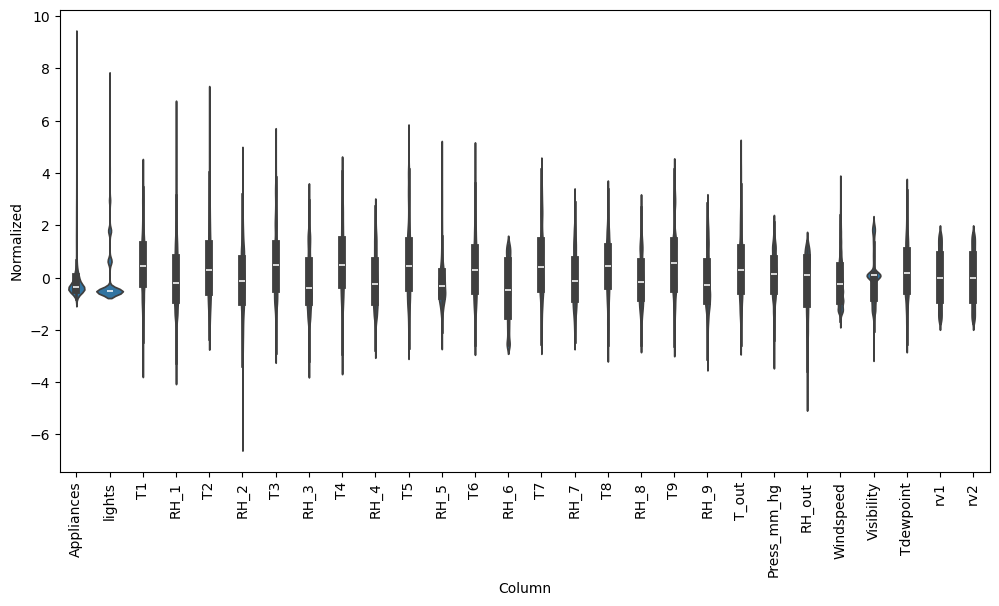

In [16]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [17]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [23]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['RH_5'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['RH_5']

In [24]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['RH_5'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['RH_5']

In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [25]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 28)
Inputs shape: (3, 6, 28)
Labels shape: (3, 1, 1)


In [28]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [30]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 28), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [31]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 28)
Labels shape (batch, time, features): (32, 1, 1)


In [34]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['RH_5'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['RH_5']

In [35]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 28)
Labels shape (batch, time, features): (32, 1, 1)
